# Classification Supervisée 

In [60]:
import pandas as pd
import numpy as np
import scipy.stats as sps
from scipy.fftpack import fft
import pywt


# Plot et Display
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Scikit learn
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression

#Lecture des données 
import pickle

In [2]:
#path_test = "../../4A/Projet/Ensemble de test/"
path_test = "../Donnees_projet/Ensemble_de_test/"

In [3]:
with open('liste_propre', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    liste_propre, ind_recupere = mon_depickler.load()

In [4]:
n = len(liste_propre)
liste_appr = list(np.asarray(liste_propre)[np.asarray(ind_recupere) <= 299])
liste_test = list(np.asarray(liste_propre)[np.asarray(ind_recupere) > 299])
n_appr = len(liste_appr)
n_test = len(liste_test)

In [5]:
anom = [False] * n_test
type_anom = [-1] * n_test
loc = [-1] * n_test

anom[73] = True
type_anom[73] = 1
loc[73] = 200

anom[96] = True
type_anom[96] = 1
loc[96] = 300

anom[36] = True
type_anom[36] = 1
loc[36] = 400

anom[32] = True
type_anom[32] = 1
loc[32] = 300

anom[33] = True
type_anom[33] = 1
loc[33] = 200

anom[107] = True
type_anom[107] = 2
loc[107] = 600

anom[60] = True
type_anom[60] = 2
loc[60] = 400

anom[113] = True
type_anom[113] = 2
loc[113] = 400

anom[9] = True
type_anom[9] = 2
loc[9] = 200

anom[11] = True
type_anom[11] = 2
loc[11] = 300

anom[53] = True
type_anom[53] = 3
loc[53] = 400

anom[114] = True
type_anom[114] = 3
loc[114] = 400

anom[14] = True
type_anom[14] = 3
loc[14] = 500

anom[79] = True
type_anom[79] = 3
loc[79] = 400

anom[29] = True
type_anom[29] = 3
loc[29] = 300

anom[27] = True
type_anom[27] = 4
loc[27] = 300

anom[121] = True
type_anom[121] = 4
loc[121] = 300

anom[5] = True
type_anom[5] = 4
loc[5] = 400

anom[89] = True
type_anom[89] = 4
loc[89] = 200

anom[99] = True
type_anom[99] = 4
loc[99] = 100  

anom = [False] * n_appr + anom
type_anom = [-1] * n_appr + type_anom
loc = [-1] * n_appr + loc

In [6]:
ind_anom = list(np.where(np.asarray(anom))[0]) # Indices des anomalies

In [7]:
def df_fenetres(liste_comp, N, anom, loc):
    serie = []
    ind_debut = []
    valeurs = []
    anom_fen = []
    for i, val, loc_i in zip(ind_recupere, liste_comp, loc):
        # Liste des fenêtres de l'enregistrement
        fenetres = [val[i * N:(i + 1) * N] for i in range((len(val) + N - 1) // N ) if len(val[i * N:(i + 1) * N]) == N]
        nb_fen = len(fenetres)
        valeurs += fenetres
        anom_fen_i = [False] * nb_fen
        pos_anom_deb_fen = loc_i // N
        pos_anom_fin_fen = (loc_i + 55) // N
        if loc_i > -1:
            try:
                for pos in range(pos_anom_deb_fen, pos_anom_fin_fen + 1):
                    anom_fen_i[pos] = True

            except IndexError:
                pass
                """Cette erreur est levée lorsque l'anomalie se trouve en fin de série, dans une plage qui n'a pas été capturée 
                par une des fenêtres. On peut donc l'ignorer et continuer le traitement. Ce cas est de toute façon très rare
                dans nos données."""
        anom_fen += anom_fen_i
        ind_debut += list(range(0, nb_fen * N, N))
        serie += [i] * nb_fen
    
    df = pd.DataFrame(data={"id" : list(range(len(serie))), "serie" : serie, "ind_debut" : ind_debut, "valeurs" : valeurs, "anom" : anom_fen})
        
    return df.set_index(["id"])

In [8]:
N = 80
data_fenetres = df_fenetres(liste_propre, N, anom, loc)

In [9]:
ind_anom = list(data_fenetres[data_fenetres["anom"]]["serie"].values)

In [32]:
# Toutes les fenetres des séries contenant une anomalie
data_ajout_anom = data_fenetres.loc[data_fenetres["serie"].isin(ind_anom)] 
# On met un indice d'une grande puisance de 10 pour identifier plus facilement les fenetres ajoutees
offset = 10 ** (int(np.log10(data_fenetres.index.values[-1])) + 1)

df_supervise = data_fenetres
for i in range(1, 3):
    data_ajout_anom.index += offset
    data_ajout_anom.serie += offset
    df_supervise = pd.concat([df_supervise, data_ajout_anom])
    
# df_supervise contient les données d'apprentissage + les données de tests + les séries anormales recopiées 4 fois
# les séries recopiées ont pour indice leur indice de départ + k*offset pour k=1,..,4
df_supervise.tail(10)

/home/charnay/.local/lib/python3.6/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,serie,ind_debut,valeurs,anom
id,,,,
23409,20414,160,"[1800.0, 1816.0, 1808.0, 1816.0, 1808.0, 1800....",False
23410,20414,240,"[1792.0, 1792.0, 1792.0, 1800.0, 1800.0, 1800....",False
23411,20414,320,"[1784.0, 1784.0, 1784.0, 1792.0, 1800.0, 1792....",False
23412,20414,400,"[1790.0, 1782.0, 1774.0, 1750.0, 1742.0, 1734....",True
23473,20421,0,"[1416.0, 1400.0, 1400.0, 1408.0, 1408.0, 1408....",False
23474,20421,80,"[1632.0, 1632.0, 1632.0, 1632.0, 1616.0, 1616....",False
23475,20421,160,"[2048.0, 2000.0, 1920.0, 1848.0, 1808.0, 1792....",False
23476,20421,240,"[1728.0, 1736.0, 1744.0, 1744.0, 1736.0, 1728....",True
23477,20421,320,"[1186.0, 1202.0, 1202.0, 1234.0, 1242.0, 1258....",True


In [33]:
print("Pourcentage initial de séries anormales : ", 20 / 425 * 100, "%")
print("Pourcentage de séries anormales après duplication : ", 60 / 465 * 100, "%")
print("Pourcentage initial de fenêtres anormales : ", data_fenetres[data_fenetres["anom"]].shape[0] / data_fenetres.shape[0] * 100, "%")
print("Pourcentage de fenêtres anormales après duplication : ", df_supervise[df_supervise["anom"]].shape[0] / df_supervise.shape[0] * 100, "%")

Pourcentage initial de séries anormales :  4.705882352941177 %
Pourcentage de séries anormales après duplication :  12.903225806451612 %
Pourcentage initial de fenêtres anormales :  0.8791832104367556 %
Pourcentage de fenêtres anormales après duplication :  2.4294670846394983 %


In [34]:
def plot_anom_type(Type):
    for num in data_fenetres.index.values:
        TS = data_fenetres.loc[num]
        loc = TS["loc"]
        serie = TS["valeurs"]

        if TS["type"] == Type: 
            fig, ax = plt.subplots(figsize=(12, 7))
            plt.title("Série numéro " + str(num) + ", type " + str(Type), size=20, color='r', fontweight='bold')

            ax.plot(range(loc), serie[: loc], 'b')
            ax.plot(range(loc - 1, loc + 56), serie[loc - 1 : loc + 56], 'r')
            ax.plot(range(loc + 55, len(serie)), serie[loc + 55 :], 'b')

        plt.show()

In [35]:
try:
    for T in range(1, 5):
        plot_anom_type(T)
except KeyError:
    print("Marche plus avec le nouveau DataFrame, à adapter si besoin.")

Marche plus avec le nouveau DataFrame, à adapter si besoin.


## Pre-Processing 

### Features

In [49]:
df_supervise["min"] = list(map(min, df_supervise.valeurs))
df_supervise["max"] = list(map(max, df_supervise.valeurs))
df_supervise["mean"] = list(map(np.mean, df_supervise.valeurs))
df_supervise["std"] = list(map(np.std, df_supervise.valeurs))
df_supervise["skew"] = list(map(sps.skew, df_supervise.valeurs))
df_supervise["kurt"] = list(map(sps.kurtosis, df_supervise.valeurs))
df_supervise["energy"] = list(map(lambda x : sum(np.asarray(x)**2)/len(x), df_supervise.valeurs))
df_supervise["average_cross"] = list(map(lambda x : sum(1*(x > np.mean(x)))/len(x), df_supervise.valeurs))

In [50]:
scaler = preprocessing.StandardScaler()
names_features = ["min", "max", "mean", "std", "skew", "kurt", "energy", "average_cross"]
for col in names_features:
    df_supervise[col] = scaler.fit_transform(df_supervise[col].values.reshape(-1, 1))

In [51]:
taille_test = df_supervise.shape[0] // 3
X_train_feat, X_test_feat, Y_train_feat, Y_test_feat = train_test_split(df_supervise[names_features], df_supervise["anom"], test_size=taille_test)

### Coefficients de Fourier

In [52]:
fftCoeff =[]
for x in df_supervise["valeurs"]:
    mx = np.mean(x)
    x_centre = x - mx
    #Apply fast Fourier transform
    coeffsfft = np.abs(fft(x_centre))
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)
    
fftCoeff = np.array(fftCoeff)
print(fftCoeff.shape)

#Coefficients seuillés
prop_a_garder = 0.1
nb_coeffs = int(fftCoeff.shape[1] * prop_a_garder)
somme = np.sum(fftCoeff**2, axis=0)
fftCoeff_seuil = np.zeros((0, nb_coeffs))
ind_grands = np.argsort(somme)[-nb_coeffs :]
fftCoeff_seuil = fftCoeff[:, ind_grands]

print(fftCoeff_seuil.shape)

(3828, 80)
(3828, 8)


In [53]:
df_Fourier = pd.DataFrame(fftCoeff)
df_Fourier_seuil = pd.DataFrame(fftCoeff_seuil)

In [54]:
for col in df_Fourier.columns :
    df_Fourier[col] = scaler.fit_transform(df_Fourier[col].values.reshape(-1, 1))
for col in df_Fourier_seuil.columns :
    df_Fourier_seuil[col] = scaler.fit_transform(df_Fourier_seuil[col].values.reshape(-1, 1))

In [55]:
taille_test = df_supervise.shape[0] // 3
X_train_fourier, X_test_fourier, Y_train_fourier, Y_test_fourier = train_test_split(df_Fourier, df_supervise["anom"], test_size=taille_test)

### Coefficients d'ondelettes

In [56]:
wavelist=['haar', 'db2']

Coeff_ond_haar = []
Coeff_ond_db2 = []

for x in df_supervise["valeurs"]:
    #Apply wavelet decomposition
    coeffs_haar = pywt.wavedec(x, wavelist[0], level=4) 
    coeffs_flatten_haar, coeff_slices_haar = pywt.coeffs_to_array(coeffs_haar)
    Coeff_ond_haar.append(coeffs_flatten_haar)
    #Apply wavelet decomposition
    coeffs_db2 = pywt.wavedec(x, wavelist[1], level=4) 
    coeffs_flatten_db2, coeff_slices_db2 = pywt.coeffs_to_array(coeffs_db2)
    Coeff_ond_db2.append(coeffs_flatten_db2)
    
Coeff_ond_haar = np.array(Coeff_ond_haar)
Coeff_ond_db2 = np.array(Coeff_ond_db2)

print(Coeff_ond_haar.shape, Coeff_ond_db2.shape)

/usr/local/insa/anaconda/lib/python3.6/site-packages/pywt/_multilevel.py:664: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[a_slices] = a_coeffs
/usr/local/insa/anaconda/lib/python3.6/site-packages/pywt/_multilevel.py:690: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  coeff_arr[slice_array] = d


(3828, 80) (3828, 89)


In [57]:
df_ond_haar = pd.DataFrame(Coeff_ond_haar)
df_ond_db2 = pd.DataFrame(Coeff_ond_db2)

In [58]:
taille_test = df_supervise.shape[0] // 3
X_train_ond, X_test_ond, Y_train_ond, Y_test_ond = train_test_split(df_ond_db2, df_supervise["anom"], test_size=taille_test)

## Régression Logistique

#### Optimisation Lasso

In [62]:
# Grille de valeurs du paramètre de pénalisaiton
param = [{"C": [12, 10, 13]}]
logitL = GridSearchCV(LogisticRegression(penalty="l1"), param, cv=5, n_jobs=-1)
logitLasso = logitL.fit(X_train_feat, Y_train_feat)
# Sélection du paramètre optimal
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" % (1. - logitLasso.best_score_, logitLasso.best_params_))

Meilleur score (apprentissage) = 0.026254, Meilleur paramètre = {'C': 12}


/home/charnay/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [68]:
# définition des estimateurs
logit = LogisticRegression(penalty="l1", C=logitLasso.best_params_["C"] )
logitOpt = logit.fit(X_train_feat, Y_train_feat)
# erreur sur l'échantillon test
print("Erreur sur l'échantillon de test : ", 1 - logitOpt.score(X_test_feat, Y_test_feat))

Erreur sur l'échantillon de test :  0.024294670846395028


/home/charnay/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [69]:
def confusion_matrices(y_chap, Y_test):
    table = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize=False) # margins=True, margins_name="Total")
    table_norm = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="all")
    table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index") # margins=True, margins_name="Total")
    table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
    sns.set(font_scale=1.4)  #for label size
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    sns.heatmap(table, annot=True, cmap="Blues", ax=ax[0, 0], annot_kws={"size": 16})  # font size
    ax[0, 0].set_title("Confusion matrix")
    sns.heatmap(table_norm, annot=True, cmap="Blues", ax=ax[0, 1], annot_kws={"size": 16}) # font size
    ax[0, 1].set_title("Normalized confusion matrix")
    sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[1, 0], annot_kws={"size": 16}) # font size
    ax[1, 0].set_title("Row-normalized confusion matrix")
    sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1, 1], annot_kws={"size": 16}) # font size
    ax[1, 1].set_title("Column-normalized confusion matrix")
    plt.show()

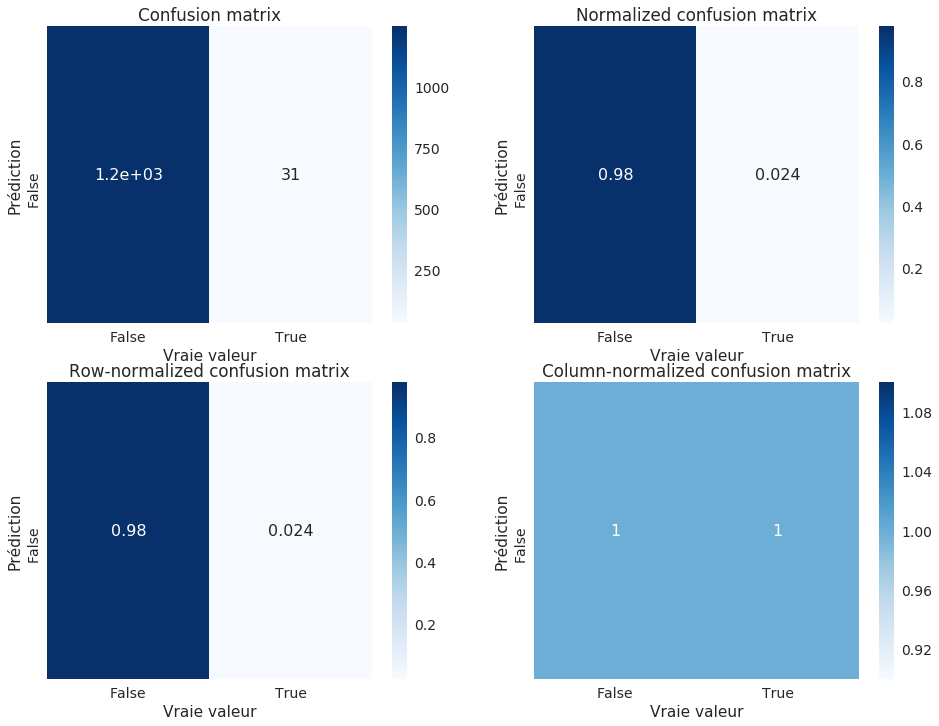

In [71]:
# prévision
y_chap = logitOpt.predict(X_test_feat)
df_supervise["pred"] = np.concatenate((np.array([False] * (df_supervise.shape[0] - len(y_chap))), y_chap))
ind_series_anom = np.unique(df_supervise[df_supervise["pred"]]["serie"].values)
# matrice de confusion
confusion_matrices(y_chap, Y_test_feat)

### Regression Logistique appliquée sur les coeffients de Fourier 

#### Optimisation Lasso

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Grille de valeurs du paramètre de pénalisaiton
param=[{"C": [2, 1, 12, 0.10, 0.012, 15, 30]}]
logitL = GridSearchCV(LogisticRegression(penalty="l1"), param, cv=5, n_jobs=-1)
logitLasso = logitL.fit(X_train, Y_train)
# Sélection du paramètre optimal
logitLasso.best_params_["C"]
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" % (1.-logitLasso.best_score_,logitLasso.best_params_))

Meilleur score (apprentissage) = 0.018417, Meilleur paramètre = {'C': 1}


/home/charnay/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [53]:
# définition des estimateurs
logit= LogisticRegression(penalty="l1", C=logitLasso.best_params_["C"] )
logitOpt=logit.fit(X_train, Y_train)
# erreur sur l'échantillon test
1-logitOpt.score(X_test, Y_test)

/home/charnay/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.023510971786833812

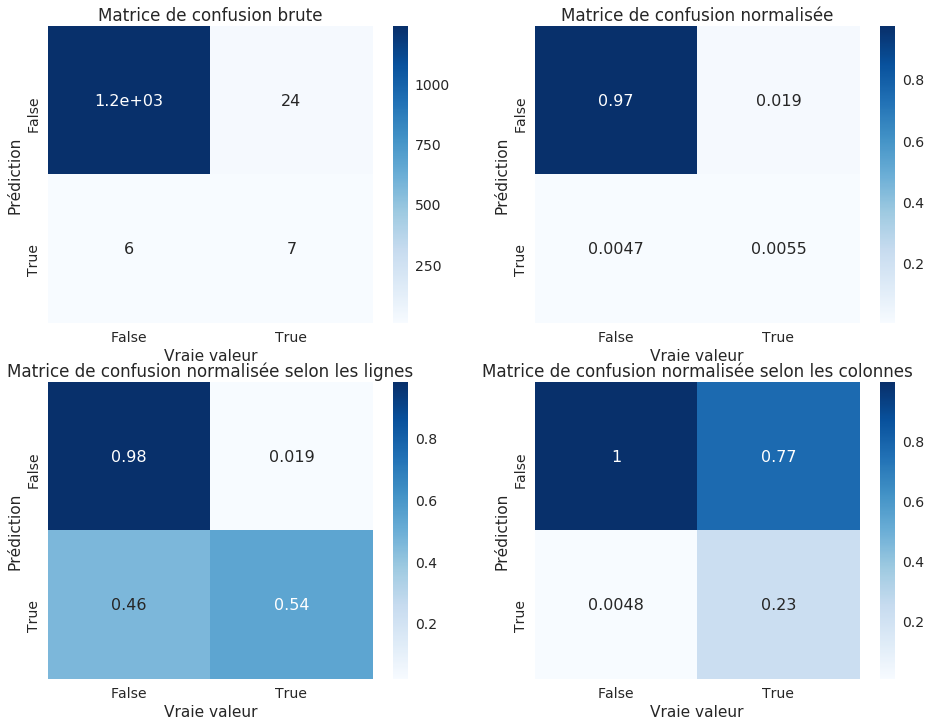

In [54]:
# prévision
y_chap = logitOpt.predict(X_test)
df_supervise["pred"] = np.concatenate((np.array([False] * (df_supervise.shape[0] - len(y_chap))), y_chap))
ind_series_anom = np.unique(df_supervise[df_supervise["pred"]]["serie"].values)
# matrice de confusion
table = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize=False) # margins=True, margins_name="Total")
table_norm = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="all")
table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="index") # margins=True, margins_name="Total")
table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prédiction"], colnames=["Vraie valeur"], normalize="columns")
sns.set(font_scale=1.4)  #for label size
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
sns.heatmap(table, annot=True, cmap="Blues", ax=ax[0, 0], annot_kws={"size": 16})  # font size
ax[0, 0].set_title("Matrice de confusion brute")
sns.heatmap(table_norm, annot=True, cmap="Blues", ax=ax[0, 1], annot_kws={"size": 16}) # font size
ax[0, 1].set_title("Matrice de confusion normalisée")
sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[1, 0], annot_kws={"size": 16}) # font size
ax[1, 0].set_title("Matrice de confusion normalisée selon les lignes")
sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1, 1], annot_kws={"size": 16}) # font size
ax[1, 1].set_title("Matrice de confusion normalisée selon les colonnes")
plt.show()

#### Optimisation Lasso

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Grille de valeurs du paramètre de pénalisaiton
param=[{"C": [2, 1, 12, 0.10, 0.012, 15, 30]}]
logitL = GridSearchCV(LogisticRegression(penalty="l1"), param, cv=5, n_jobs=-1)
logitLasso = logitL.fit(X_train, Y_train)
# Sélection du paramètre optimal
logitLasso.best_params_["C"]
print("Meilleur score (apprentissage) = %f, Meilleur paramètre = %s" % (1.-logitLasso.best_score_,logitLasso.best_params_))

/home/charnay/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Meilleur score (apprentissage) = 0.020768, Meilleur paramètre = {'C': 0.012}


In [59]:
# définition des estimateurs
logit= LogisticRegression(penalty="l1", C=logitLasso.best_params_["C"] )
logitOpt=logit.fit(X_train, Y_train)
# erreur sur l'échantillon test
1-logitOpt.score(X_test, Y_test)

/home/charnay/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.026645768025078342

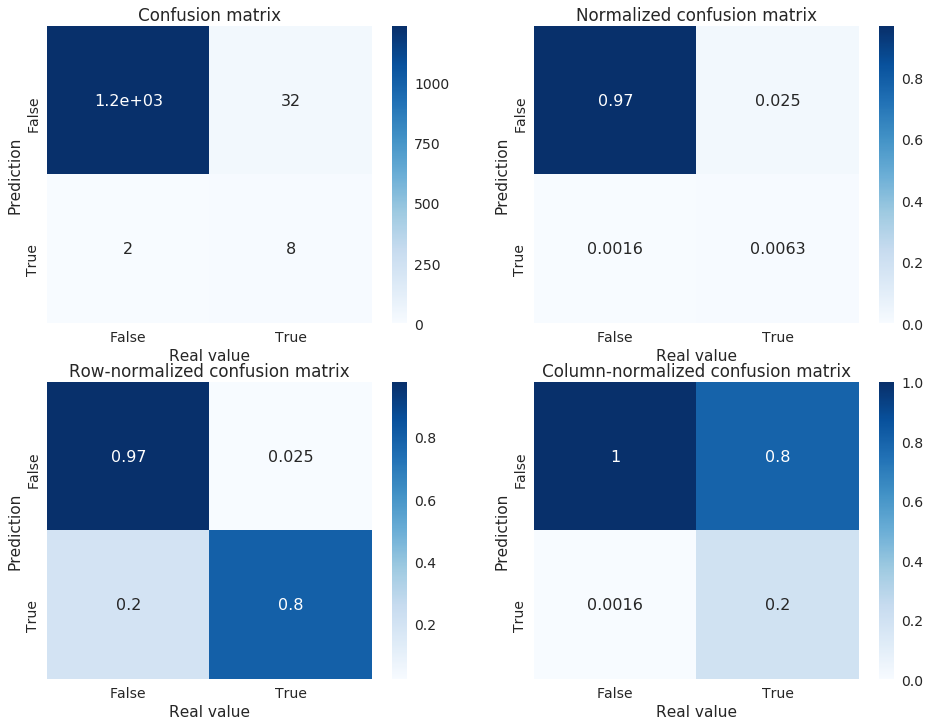

In [63]:
# prévision
y_chap = logitOpt.predict(X_test)
df_supervise["pred"] = np.concatenate((np.array([False] * (df_supervise.shape[0] - len(y_chap))), y_chap))
ind_series_anom = np.unique(df_supervise[df_supervise["pred"]]["serie"].values)
# matrice de confusion
table = pd.crosstab(y_chap, Y_test, rownames=["Prediction"], colnames=["Real value"], normalize=False) # margins=True, margins_name="Total")
table_norm = pd.crosstab(y_chap, Y_test, rownames=["Prediction"], colnames=["Real value"], normalize="all")
table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prediction"], colnames=["Real value"], normalize="index") # margins=True, margins_name="Total")
table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prediction"], colnames=["Real value"], normalize="columns")
sns.set(font_scale=1.4)  #for label size
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
sns.heatmap(table, annot=True, cmap="Blues", ax=ax[0, 0], annot_kws={"size": 16})  # font size
ax[0, 0].set_title("Confusion matrix")
sns.heatmap(table_norm, annot=True, cmap="Blues", ax=ax[0, 1], annot_kws={"size": 16}) # font size
ax[0, 1].set_title("Normalized confusion matrix")
sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[1, 0], annot_kws={"size": 16}) # font size
ax[1, 0].set_title("Row-normalized confusion matrix")
sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1, 1], annot_kws={"size": 16}) # font size
ax[1, 1].set_title("Column-normalized confusion matrix")
plt.show()

## Random Forest 

### Visualisation des résultats

In [64]:
# Interactive display
from ipywidgets import interact, widgets, interactive, fixed, interact_manual
from IPython.display import display

df_liste = ["Features",
            "Ondelettes_haar",
            "Ondelettes_db2",
            "Coefficients de Fourier",
            "Coefficients de Fourier seuillés"
           ]

dict_df = {"Features" : df_supervise[names_features],
           "Ondelettes_haar" : df_ond_haar,
           "Ondelettes_db2" : df_ond_db2,
           "Coefficients de Fourier" : df_Fourier,
           "Coefficients de Fourier seuillés" : df_Fourier_seuil
          }

taille_max = df_supervise.shape[0]
print(taille_max)

3828


In [65]:
@interact(Choix_df=df_liste, taille_test=widgets.IntSlider(min=100, max=taille_max - 100, step=100, 
                                                           value=taille_max//3, continuous_update=False), 
          button=widgets.ToggleButton(description="Refresh"))

def RandomForest(Choix_df, taille_test, button):
    df_coeff = dict_df[Choix_df]
    #print("Proportion de fenêtres utilisées pour l'apprentissage : ", 1 - taille_test / df_coeff.shape[0])
    X_train, X_test, Y_train, Y_test = train_test_split(df_coeff, df_supervise["anom"], test_size=taille_test)
    
    # définition des paramètres
    
    # apprentissage
    
    max_feat = 5
    param = [{"max_features" : list(range(2, min(max_feat, df_coeff.shape[1]) + 1))}]
    rf = GridSearchCV(RandomForestClassifier(n_estimators=500), param, cv=5, n_jobs=-1)

    rfOpt = rf.fit(X_train, Y_train)
    
    #print("Erreur Out of bag : ", 1 - rfOpt.oob_score_)  # N'existe pas sur les objets GridSearchCV, hélas
    # erreur de prévision sur le test
    #print("Erreur de prévision sur le test : ", 1 - rfOpt.score(X_test, Y_test))
    # paramètre optimal
    #print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_, rfOpt.best_params_))
    
    forest = RandomForestClassifier(n_estimators=500, criterion='gini', max_depth=None, min_samples_split=2,
                                    min_samples_leaf=1, max_features=rfOpt.best_params_['max_features'], 
                                    max_leaf_nodes=None, bootstrap=True, oob_score=True)
    rfFit = forest.fit(X_train, Y_train)
    
    # prévision
    y_chap = rfOpt.predict(X_test)
    
    
    df_supervise["pred"] = np.array([False] * df_supervise.shape[0])
    for ind, ind_fen in enumerate(Y_test.index):
        df_supervise.loc[ind_fen, "pred"] = y_chap[ind]
        
    ind_series_anom = np.unique(df_supervise[df_supervise["pred"]]["serie"].values)
    print("Séries contenant une anomalie : ", ind_series_anom)
    # matrice de confusion

    table = pd.crosstab(y_chap, Y_test, rownames=["Prediction"], colnames=["Real value"], normalize=False) # margins=True, margins_name="Total")
    table_norm = pd.crosstab(y_chap, Y_test, rownames=["Prediction"], colnames=["Real value"], normalize="all")
    table_norm_index = pd.crosstab(y_chap, Y_test, rownames=["Prediction"], colnames=["Real value"], normalize="index") # margins=True, margins_name="Total")
    table_norm_col = pd.crosstab(y_chap, Y_test, rownames=["Prediction"], colnames=["Real value"], normalize="columns")
    sns.set(font_scale=1.4)  #for label size
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))
    sns.heatmap(table, annot=True, cmap="Blues", ax=ax[0, 0], annot_kws={"size": 16})  # font size
    ax[0, 0].set_title("Confusion matrix")
    sns.heatmap(table_norm, annot=True, cmap="Blues", ax=ax[0, 1], annot_kws={"size": 16}) # font size
    ax[0, 1].set_title("Normalized confusion matrix")
    sns.heatmap(table_norm_index, annot=True, cmap="Blues", ax=ax[1, 0], annot_kws={"size": 16}) # font size
    ax[1, 0].set_title("Row-normalized confusion matrix")
    sns.heatmap(table_norm_col, annot=True, cmap="Blues", ax=ax[1, 1], annot_kws={"size": 16}) # font size
    ax[1, 1].set_title("Column-normalized confusion matrix")
    plt.show()

    for num in ind_series_anom:

        fig, ax = plt.subplots(figsize=(8, 5))
        TS = df_supervise[(df_supervise["serie"] == num)]["valeurs"].values
        anoms = df_supervise[df_supervise["serie"] == num]["pred"].values
        title_obj = plt.title("Série numéro " + str(num % offset), size=25)
        for (i, x), anom in zip(enumerate(TS), anoms):

            if i > 0:  # Raccordement
                ax.plot([N * i - 1, N * i], [last, x[0]], "br"[int(anom)])

            ax.plot(range(N * i, N * (i + 1)),  x, "br"[int(anom)])
            last = x[-1]
            if anom:
                plt.setp(title_obj, color='r', fontweight="bold")
    
        plt.show()

interactive(children=(Dropdown(description='Choix_df', options=('Features', 'Ondelettes_haar', 'Ondelettes_db2…